In [1]:
from pathlib import Path
import numpy as np
import datetime
import json
import os
import pandas as pd
import rasterio
from PIL import Image
from cropmask.coco_convert import split_save_train_validation_test_df, save_coco_annotation, create_coco_dataset
from cropmask.misc import parse_yaml, make_dirs

from cropmask import detectron2_reclass # fair amount of stuff goes on in here to make detectron work for this project.
from detectron2.data.datasets import register_coco_instances, load_coco_json

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import cv2
import random
from skimage.io import imshow, imread
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor, launch
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from cropmask.misc import max_normalize, percentile_rescale
from cropmask.detectron2_cropmask_cfg import cfg
from cropmask import detectron2_reclass # fair amount of stuff goes on in here to make detectron work for this project.

tiles_path = Path(cfg.DATASET_PATH) / "tiles"
train, validation, test = split_save_train_validation_test_df(tiles_path, save_empty_tiles=False)
coco_path = Path(cfg.DATASET_PATH) / "coco"

def read_and_mean(path):
    arr = rasterio.open(path).read()
    fill_values = np.mean(arr, axis=tuple(range(1, arr.ndim)))
    return fill_values
    
def read_and_variance(path):
    arr = rasterio.open(path).read()
    fill_values = np.var(arr, axis=tuple(range(1, arr.ndim)))
    return fill_values

def calc_stat(df, func, include_empty=False):
    """
    func should operate on a single array of order [band, H, W]
    """
    df = df.copy()
    new_df = df[df.is_empty == include_empty]
    new_df['fill_values'] = new_df['image_tiles'].apply(func)
    new_df = pd.DataFrame(new_df.fill_values.tolist(), columns=['0', '1', '2'])
    return new_df

def max_norm_channels(arr):
    """
    arr must be of shape (w, h, channel)
    """
    arr = arr.copy()
    maxes = np.nanmax(arr, axis=(0,1))
    return arr / maxes

def make_vis_im(img):
    img = img[:, :, ::-1]
    normalized = max_norm_channels(np.where(img < 0, 0, img))
    rescaled = rescale_intensity(normalized, out_range=(0,255))
    masked = np.where(rescaled==0, np.nan, rescaled)
    return masked

mean_df = calc_stat(train, read_and_mean)
var_df = calc_stat(train, read_and_variance)

channel_means = mean_df.mean(axis=0).values
channel_stds = np.sqrt(var_df.mean(axis=0).values)

train_coco_instances_path = str(coco_path / "instances_train.json")
val_coco_instances_path = str(coco_path / "instances_val.json")
test_coco_instances_path = str(coco_path / "instances_test.json")

/home/ryan/miniconda3/envs/cropmask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ryan/miniconda3/envs/cropmask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ryan/miniconda3/envs/cropmask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ryan/miniconda3/envs/cropmask/lib/pyt

In [2]:
if (coco_path / "instances_train.json").exists() is False:
    train_coco_dict = create_coco_dataset(train)
    val_coco_dict = create_coco_dataset(validation)
    test_coco_dict = create_coco_dataset(test)
    save_coco_annotation(train_coco_instances_path, train_coco_dict)
    save_coco_annotation(val_coco_instances_path, val_coco_dict)
    save_coco_annotation(test_coco_instances_path, test_coco_dict)
# register each val and test set if there are more than one.
register_coco_instances(cfg.DATASETS.TRAIN[0], {}, train_coco_instances_path, str(next(tiles_path.glob("*image*"))))
register_coco_instances(cfg.DATASETS.VALIDATION[0], {}, val_coco_instances_path, str(next(tiles_path.glob("*image*"))))
register_coco_instances(cfg.DATASETS.TEST[0], {}, test_coco_instances_path, str(next(tiles_path.glob("*image*"))))

train_json = load_coco_json(train_coco_instances_path,  str(next(tiles_path.glob("*image*"))))
val_json = load_coco_json(val_coco_instances_path,  str(next(tiles_path.glob("*image*"))))
test_json = load_coco_json(test_coco_instances_path,  str(next(tiles_path.glob("*image*"))))
try:
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=False)
except:
    pass

[02/14 01:11:28 d2.data.datasets.coco]: Loading /datadrive/test-ard-june-sept-nirrg/coco/instances_train.json takes 1.84 seconds.
[02/14 01:11:28 d2.data.datasets.coco]: Loaded 377 images in COCO format from /datadrive/test-ard-june-sept-nirrg/coco/instances_train.json
[02/14 01:11:29 d2.data.datasets.coco]: Loaded 42 images in COCO format from /datadrive/test-ard-june-sept-nirrg/coco/instances_val.json
[02/14 01:11:29 d2.data.datasets.coco]: Loaded 47 images in COCO format from /datadrive/test-ard-june-sept-nirrg/coco/instances_test.json


In [3]:
print(channel_means)
print(channel_stds)

[ 931.90757125 1001.46930161 2793.30379383]
[262.82447442 340.61644907 559.11205354]


### Printing Truth Labels and Images

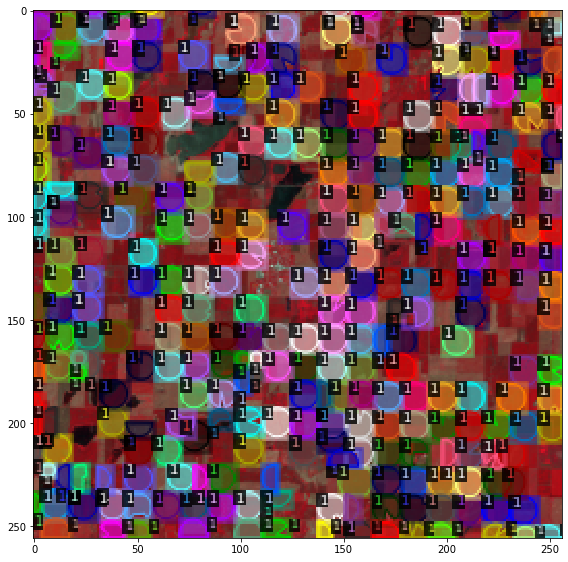

In [4]:

for d in random.sample(train_json, 1):
    if len(d['annotations']) > 0:
        img = imread(d["file_name"])
        img = img[:, :, ::-1]
        normalized = max_norm_channels(np.where(img < 0, 0, img))
        rescaled = rescale_intensity(normalized, out_range=(0,255))
        masked = np.where(rescaled==0, np.nan, rescaled)
        visualizer = Visualizer(masked, metadata={}, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        plt.figure(figsize = (8,16))
        imshow(vis.get_image())

# Model Inspection

In [6]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0000799.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

Need to fix so that predictor does not use PIL.

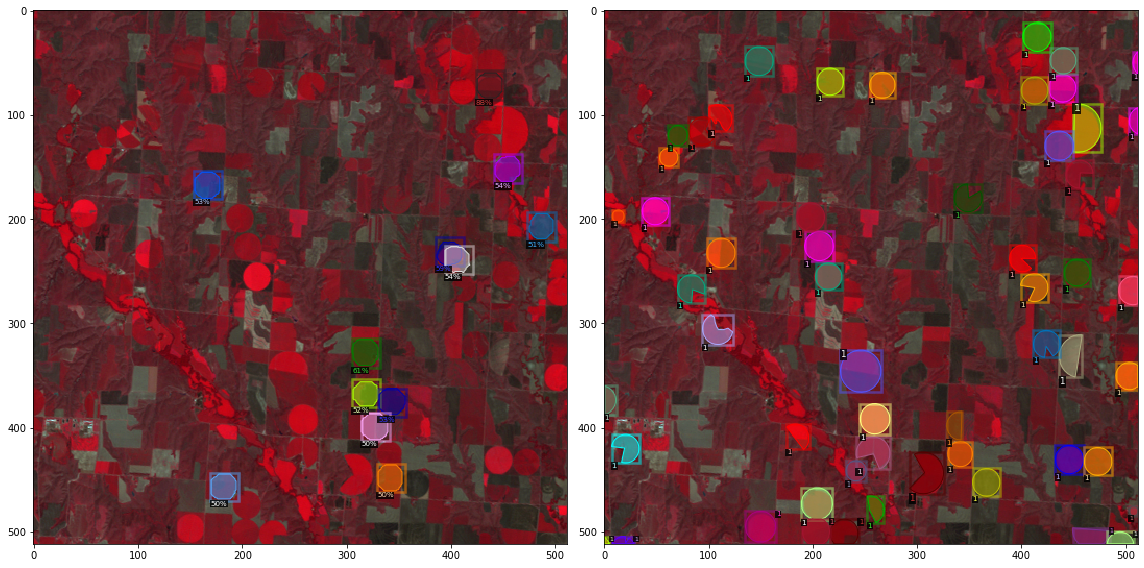

In [23]:
from detectron2.utils.visualizer import ColorMode
for d in random.sample(test_json, 1):    
    im = imread(d["file_name"])
    outputs = predictor(im)
    vis_im = make_vis_im(im)
    visualizer_preds = Visualizer(vis_im,
                   scale=1, 
                   metadata= {}   # remove the colors of unsegmented pixels
    )
    visualizer_labels = Visualizer(vis_im,
                   scale=1, 
                   metadata= {}   # remove the colors of unsegmented pixels
    )
    v = visualizer_preds.draw_instance_predictions(outputs["instances"].to("cpu"))
    labels = visualizer_labels.draw_dataset_dict(d)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,16))
    imshow(v.get_image(), ax=ax[0])
    imshow(labels.get_image(), ax=ax[1])

In [20]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("test", cfg, False, output_dir="/datadrive/evaluator_output/")
test_loader = build_detection_test_loader(cfg, "test")

[02/05 22:47:08 d2.data.datasets.coco]: Loaded 47 images in COCO format from /datadrive/test-ard-june-sept-nirrg/coco/instances_test.json
[02/05 22:47:08 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   other    | 4234         |
|            |              |


In [21]:
?inference_on_dataset

Signature: inference_on_dataset(model, data_loader, evaluator)
Docstring:
Run model on the data_loader and evaluate the metrics with evaluator.
Also benchmark the inference speed of `model.forward` accurately.
The model will be used in eval mode.

Args:
    model (nn.Module): a module which accepts an object from
        `data_loader` and returns some outputs. It will be temporarily set to `eval` mode.

        If you wish to evaluate a model in `training` mode instead, you can
        wrap the given model and override its behavior of `.eval()` and `.train()`.
    data_loader: an iterable object with a length.
        The elements it generates will be the inputs to the model.
    evaluator (DatasetEvaluator): the evaluator to run. Use `None` if you only want
        to benchmark, but don't want to do any evaluation.

Returns:
    The return value of `evaluator.evaluate()`
File:      ~/detectron2/detectron2/evaluation/evaluator.py
Type:      function


In [ ]:
inference_on_dataset(trainer.model, test_loader, evaluator)
# another equivalent way is to use trainer.test